number of days to reach 80% accuracy on easy trials: 
12


<Figure size 432x288 with 0 Axes>

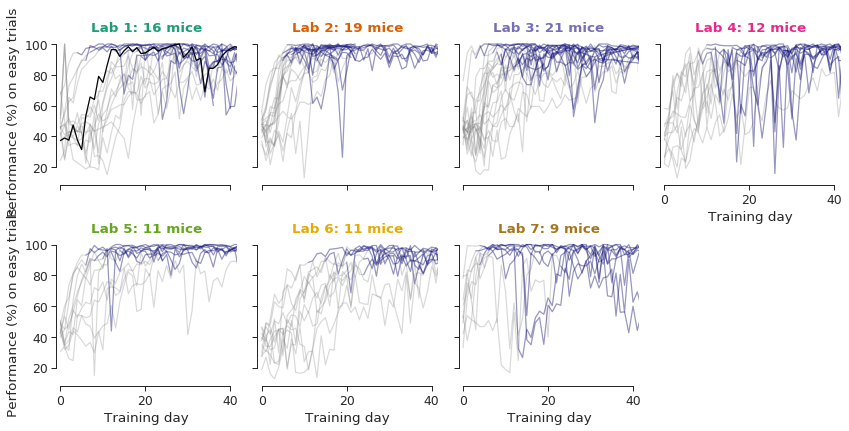

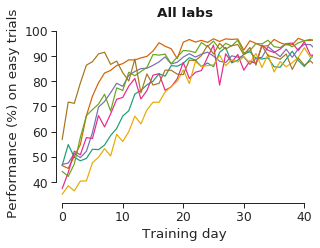

In [2]:
"""
Learning curves for all labs
@author: Anne Urai
15 January 2020
"""

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from paper_behavior_functions import (query_subjects, seaborn_style, figpath,
                                      group_colors, institution_map, seaborn_style)
from ibl_pipeline.analyses import behavior as behavioral_analyses

import warnings
warnings.filterwarnings("ignore")

# INITIALIZE A FEW THINGS
seaborn_style()
pal = group_colors()
institution_map, col_names = institution_map()
col_names = col_names[:-1]

# ================================= #
# GET DATA FROM TRAINED ANIMALS
# ================================= #

use_subjects = query_subjects()
b = (behavioral_analyses.BehavioralSummaryByDate * use_subjects)
behav = b.fetch(order_by='institution_short, subject_nickname, training_day',
                format='frame').reset_index()
behav['institution_code'] = behav.institution_short.map(institution_map)

# how many mice are there for each lab?
N = behav.groupby(['institution_code'])['subject_nickname'].nunique().to_dict()
behav['n_mice'] = behav.institution_code.map(N)
behav['institution_name'] = behav.institution_code + \
    ': ' + behav.n_mice.apply(str) + ' mice'

# make sure each mouse starts at 0
for index, group in behav.groupby(['lab_name', 'subject_nickname']):
    behav['training_day'][behav.index.isin(
        group.index)] = group['training_day'] - group['training_day'].min()

# create another column only after the mouse is trained
behav2 = pd.DataFrame([])
for index, group in behav.groupby(['institution_code', 'subject_nickname']):
    group['performance_easy_trained'] = group.performance_easy
    group.loc[group['session_date'] < pd.to_datetime(group['date_trained']),
              'performance_easy_trained'] = np.nan
    # add this
    behav2 = behav2.append(group)

behav = behav2
behav['performance_easy'] = behav.performance_easy * 100
behav['performance_easy_trained'] = behav.performance_easy_trained * 100

# ================================= #
# LEARNING CURVES
# ================================= #

# plot one curve for each animal, one panel per lab
fig = sns.FacetGrid(behav,
                    col="institution_code", col_wrap=4, col_order=col_names,
                    sharex=True, sharey=True, aspect=1, hue="subject_uuid", xlim=[-1, 41.5])
fig.map(sns.lineplot, "training_day",
        "performance_easy", color='gray', alpha=0.3)
fig.map(sns.lineplot, "training_day",
        "performance_easy_trained", color='darkblue', alpha=0.3)
fig.set_titles("{col_name}")
for axidx, ax in enumerate(fig.axes.flat):
    ax.set_title(behav.institution_name.unique()[
                 axidx], color=pal[axidx], fontweight='bold')

# overlay the example mouse
sns.lineplot(ax=fig.axes[0], x='training_day', y='performance_easy', color='black',
             data=behav[behav['subject_nickname'].str.contains('KS014')], legend=False)

fig.set_axis_labels('Training day', 'Performance (%) on easy trials')
fig.despine(trim=True)

# Plot all labs
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
sns.lineplot(x='training_day', y='performance_easy', hue='institution_code', palette=pal,
             ax=ax1, legend=False, data=behav, ci=None)
ax1.set_title('All labs', color='k', fontweight='bold')
ax1.set(xlabel='Training day',
        ylabel='Performance (%) on easy trials', xlim=[-1, 41.5])

seaborn_style()
plt.tight_layout(pad=2)
fig.show()

# ================================= #
# print some stats
# ================================= #
behav_summary_std = behav.groupby(['training_day'])[
    'performance_easy'].std().reset_index()
behav_summary = behav.groupby(['training_day'])[
    'performance_easy'].mean().reset_index()
print('number of days to reach 80% accuracy on easy trials: ')
print(behav_summary.loc[behav_summary.performance_easy >
                        80, 'training_day'].min())